In [2]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from umap import UMAP
import os

c:\Users\Mello\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("dataset.csv")
df.head()

,ClassLabel,X01,Y01,Z01,X11,Y11,Z11,X21,Y21,Z21,...,Z6219,X6319,Y6319,Z6319,X6419,Y6419,Z6419,X6519,Y6519,Z6519
0,Boy,1.0,0.547994,0.000000,1.0,0.547994,0.000000,1.0,0.547994,0.000000,...,0.071914,0.272580,0.322938,0.127316,0.228388,0.264486,0.084617,0.265310,0.313749,0.177373
1,Boy,1.0,0.857104,0.379246,1.0,0.857104,0.379246,1.0,0.857104,0.379246,...,0.265342,0.458347,0.407922,0.230979,0.368018,0.479731,0.278366,0.415877,0.466096,0.319931
2,Boy,1.0,0.852530,0.358460,1.0,0.852530,0.358460,1.0,0.852530,0.358460,...,0.252582,0.462702,0.409546,0.237752,0.368986,0.483866,0.267000,0.418716,0.471061,0.319184
3,Boy,1.0,0.778636,0.000000,1.0,0.778636,0.000000,1.0,0.778636,0.000000,...,0.003979,0.426772,0.485623,0.153090,0.321029,0.400402,0.032188,0.410688,0.467018,0.270999
4,Boy,1.0,0.589883,0.119620,1.0,0.589883,0.119620,1.0,0.589883,0.119620,...,0.380987,0.487479,0.526593,0.386855,0.465436,0.526274,0.390475,0.482003,0.520124,0.418845


In [4]:
y = df['ClassLabel'].values
X = df.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [5]:
df.fillna(0, inplace=True)

In [6]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [7]:
print("Original X_train size:", X_train.size)
print("Expected size after reshaping:", 577 * 198 * 19 * 1)

# Add this line to check the dimensions of X_train before reshaping
print("X_train dimensions before reshaping:", X_train.shape)

Original X_train size: 2170674
Expected size after reshaping: 2170674
X_train dimensions before reshaping: (577, 3762)


In [8]:
# Model Traiining using CNN

import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap



In [9]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[: , :])
X_test_norm = mms.transform(X_test[:, :])



In [10]:
reducer = umap.UMAP(
    n_components=2,
    #min_dist=0.8,
    metric='cosine',
    n_jobs=-1
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

c:\Users\Mello\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyDeepInsight\image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


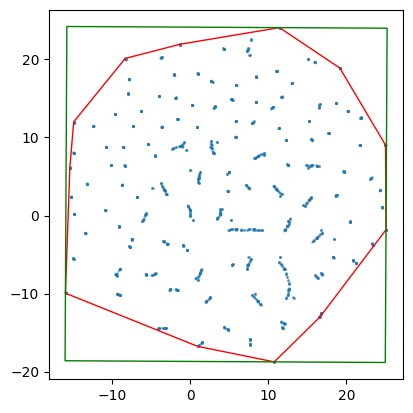

In [11]:
X_train_norm = np.nan_to_num(X_train_norm)
X_test_norm = np.nan_to_num(X_test_norm)

it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

In [12]:
import numpy as np
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [14]:
batch_size=50
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=1e-02,
    momentum=0.9,
)

In [16]:
net.train()
for epoch in range(15):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        # Convert labels to Long type
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 001, batch 002'

In [ ]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The test accuracy was 0.855


In [ ]:
# Save the model as .h5 file
net.save('cnn_model_keras2.h5')